# Distancia de frenado

Guido Salazar

13/08/2024

## Librerias

In [55]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.linalg as la

In [56]:
def gauss_newton(r, x0, tol=0.001, iter=1000, fixed_lambda=50):
  """
  Función que calcula los parametros de una función usando minimos cuadrados no
  lineales
  Entradas: r: Función en Rn -> Rm con los errores relativos
            x0: valor inicial
            tol: tolerancia
            iter: maximo de iteraciones
  Salida: ans: tupla con los valores que solución el sistema de ecuaciones de
               los errores relativos obtenido y un mensaje en caso de que el
               metodo si converge, falla o no converge
  """
  simb_x = [sym.Symbol("x" + str(i)) for i in range(len(x0))] #Creación de variables simbolicas igual a la cantidad de elementos en el valor inicial
  mat = sym.Matrix(r(simb_x)) #sympy matrix para la función f de numpy
  Dr = sym.lambdify([simb_x], mat.jacobian(simb_x)) #Hallar la jacobiana y transformarla en un array de numpy
  i, y, ans, flag = 0, x0, None, True #Creación del iterador, respuesta del metodo, salida, y una bandera por si el metodo falla
  delta = np.array([1 for _ in range(len(x0))])
  while np.linalg.norm(delta) >= tol and i < iter and flag: #Mientras el resultado cumpla con la tolerancia, o no se halla llegado al numero de iteraciones o la bandera sea cierta
      #Sea A = Dr(x0)
      #Creación del sistema de ecuacions (ATA+lambda*diag(A^T, T))delta = ATr(x) => Ay = b
      # x_k+1 = x_k + delta
      A = Dr(x0)
      b = r(x0)
      b = -np.dot(np.transpose(A), b)
      A = np.dot(np.transpose(A), A)
      A += fixed_lambda*np.diag(np.diag(A))
      #Resolver el sistemas de ecuaciones usando QR Ax=b => QRx=b => Rx = Q^{-1}b => Rx = Q^Tb
      Q,R = np.linalg.qr(A) # qr decomposition of A
      QT = np.transpose(Q)
      y = np.dot(QT, b)
      delta = np.linalg.solve(R, y)
      x0 = np.array(delta + x0)
      i += 1
  if i >= iter and flag: ans = (np.array(x0), "No encontrado")
  elif flag: ans = (np.array(x0), "Encontrado")
  return ans

## Modelo general

¿Qué pasaría si te encontraras en una situación de inminente peligro ante un posible choque que podría haberse evitado manteniendo una mayor distancia de maniobra con el objeto en cuestión? ¿A qué distancia deberías estar para evitar un choque? Estas y muchas otras preguntas se intentarán responder a través de un análisis matemático, con el fin de determinar la distancia adecuada de frenado vehicular para evitar un accidente catastrófico.

Para esto, partimos de la idea de que al conducir un vehículo, nos enfrentamos a dos momentos cruciales a la hora de evitar un accidente cuando percibimos el estímulo antes del choque:

1.   La reacción del individuo para activar el freno del vehículo, la cual denominaremos como la distancia de reacción, medida en metros ($g(x)$).
2.   La distancia de frenado, que es la distancia en la que el vehículo se detiene por completo desde el momento de la activación del freno ($h(x)$).

De este modo, obtenemos una fórmula general para medir la distancia de frenado de un vehículo, dada por:

$$
f(x) = g(x) + h(x)
$$

Por esta razón, en este trabajo se propondrán dos funciones, $g(x)$ y $h(x)$, que permitirán estimar la distancia de frenado de un vehículo dadas unas condiciones iniciales.


### Identificación de variables y parametros

Para ofrecer las dos funciones, es necesario analizar las variables y parámetros que influyen en una persona al momento de frenar ante un estímulo. En este contexto, existen dos posibles familias de parámetros: aquellos que afectan la reacción del individuo, y por lo tanto la distancia de reacción, y aquellos que influyen en el frenado vehicular.

En estas dos grandes familias de parámetros, podemos encontrar factores externos que afectan los distintos frenados, como la visibilidad de la persona, las condiciones climáticas, las condiciones de la vía, etc. También existen factores internos (del conductor o del vehículo) como la edad de la persona, la experiencia, el estado de los frenos, el estado de los neumáticos, etc. Por esta razón, esta tarea no es sencilla, y es necesario identificar los parámetros más significativos para lograr una buena abstracción y simplificación del modelo.



**Variables**: Dentro del modelo, se identifica como variable la velocidad con la que el individuo se desplaza al momento de recibir el estímulo, identificada como $v_{ie}$, y la velocidad que lleva al comenzar el frenado, identificada como $v_{if}$.

---

**Parámetros:**



1.  *Factores externos*
 - Visibilidad
 - Condiciones climáticas
 - Inclinación de la carretera (asumiendo que la carretera no cambia desde que se percibe el estímulo)
 - Coeficiente de fricción de la carretera (asumiendo que el frenado se realiza sobre un mismo material)
 - Contaminación visual
 - Ayudas de frenado automático
2.   Factores internos
 - Estado de los neumáticos
 - Nivel de cansancio
 - Embriaguez
 - Drogas
 - Masa del vehículo
 - Edad
 - Género
 - Experiencia
 - Estado de los frenos


---

**Depuración de Parámetros**

Dependencia de parámetros:

* Factor de cansancio (sueño, embriaguez, drogas)
* Tiempo de reacción (edad, género, experiencia, factor de cansancio, visibilidad, contaminación visual)
* Coeficiente de fricción ajustado (coeficiente de fricción de la carretera, condiciones climáticas, estado de los neumáticos, estado de los frenos, ayudas de frenado automático)
* Fuerza de fricción (coeficiente de fricción ajustado, fuerza normal)
* Fuerza normal (peso, ángulo de inclinación)
* Peso (masa, gravedad)


### Abstración de los modelos

Previamente se mencionó que la distancia de frenado depende de dos grandes momentos: la distancia de reacción $g(x)$ y la distancia de frenado $h(x)$.

#### Calculo de la función $g(x)$

Partiendo de la idea de que ambas funciones pueden ser expresadas mediante la cinemática que estudia la trayectoria de un cuerpo a lo largo del tiempo, se puede asumir que la función de distancia $g(x)$ se comporta como un movimiento rectilíneo uniforme, donde la fórmula general de dichos movimientos es:

$$
mru(t) = tv_i + d_0
$$

Donde el tiempo se define como el tiempo de reacción $t_r$, que depende de otros parámetros, la velocidad es $v_i = v_{ie}$ y $d_0 = 0$. Por lo tanto, la ecuación anterior resulta en:

$$
g(v_{ie}) = t_r v_{ie}
$$

#### Calculo de la función $h(x)$

Con la función $h(x)$, tenemos un comportamiento similar al del movimiento uniformemente acelerado, cuya fórmula general viene dada por:

$$
h(t) = \frac{1}{2}a t^2 + v_0t + d_0
$$

donde $d_0 = 0$. A su vez, $t = \frac{v_f - v_0}{a}$, por lo que la ecuación queda como:

$$
h(v_i) = \frac{1}{2}a \left(\frac{v_f - v_0}{a}\right)^2 + v_0\frac{v_f - v_0}{a} \\
h(v_i) = \frac{\left(v_f - v_0\right)^2}{2a} + v_0\frac{v_f - v_0}{a} \\
h(v_i) = \left(\frac{v_f - v_0}{a}\right) \left(\frac{v_f - v_0}{2} + v_0\right) \\
h(v_i) = \left(\frac{v_f - v_0}{a}\right) \left(\frac{v_f - v_0 + 2v_0}{2}\right) \\
h(v_i) = \left(\frac{v_f - v_0}{a}\right) \left(\frac{v_f + v_0}{2}\right) \\
h(v_i) = \frac{\left(v_f - v_0\right)\left(v_f + v_0\right)}{2a} \\
h(v_i) = \frac{v_f^2 - v_0^2}{2a}
$$

donde $v_f = 0$. Por lo tanto, la ecuación resulta en:

$$h(v_i) = \frac{-v_0^2}{2a}$$

Para este movimiento, tenemos una serie de variables y parámetros que debemos determinar a partir de otros.

##### Calculo de la aceleración

Para hallar la aceleración del carro, debemos entender cómo actúan las fuerzas que se oponen al movimiento del vehículo. En este caso, las fuerzas relevantes para el frenado del carro son la fuerza de fricción y el peso del carro. Las fuerzas que intervienen en el frenado se describen mediante la siguiente ecuación:

$$0=F_μ + F_t - F$$

donde la fuerza de fricción se calcula como $F_μ = μ_{act} N$, con $N$ siendo la fuerza normal al suelo, calculada como $W \cos{α}$, y $F_t = W \sin{α}$, donde $W$ es la fuerza peso del vehículo ($mg$) y $α$ es el ángulo de inclinación de la vía. Por lo tanto, si $F = ma$, entonces:

$$
0 = F_μ + F_t - F \\
F = F_μ + F_t \\
ma = μ_{act}N + W \sin{α} \\
ma = μ_{act}W\cos{α} + W \sin{α} \\
ma = W \left(μ_{act}\cos{α} + \sin{α} \right) \\
ma = mg \left(μ_{act}\cos{α} + \sin{α} \right) \\
a = g \left(μ_{act}\cos{α} + \sin{α} \right)
$$

donde $a$ es un vector con sentido contrario a la velocidad, por lo cual es negativo.

#### Conclusión

Con el procedimiento anterior, se puede definir $f(x) = g(x) + h(x)$ donde $x = v_{ie} = v_{if} = v$, como:

$$
f(v) = t_r v + \frac{-v^2}{2a} \\
f(v) = t_r v + \frac{-v^2}{2 \left(-g \left(μ_{act}\cos{α} + \sin{α} \right)\right)} \\
f(v) = t_r v + \frac{v^2}{2g\left(μ_{act}\cos{α} + \sin{α} \right)} \\
f(v) = t_r v + \frac{v^2}{2g\cos{α}\left(μ_{act} + \frac{\sin{α}}{\cos{α}} \right)} \\
f(v) = t_r v + \frac{v^2}{2g\cos{α}\left(μ_{act} + \tan{α} \right)} \\
$$

### Simplificación del Modelo

**Coeficientes de fricción**

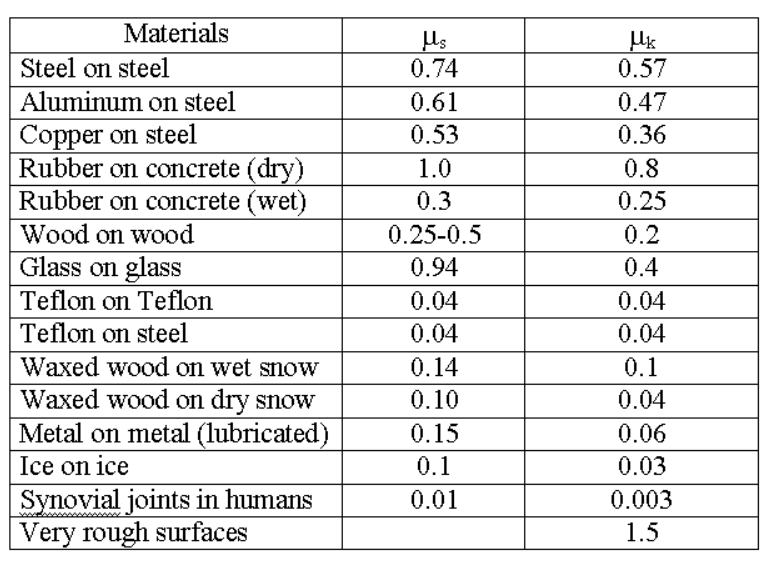

**Sacado de:** Crede, V. General Physics A - Fall 2019
Studio. Florida State University. [Online 13/08/2024] https://hadron.physics.fsu.edu/~crede/TEACHING/PHY2048C/Calendar/W6_D1/Friction%20Coefficients.htm

**Tiempo de reacción**

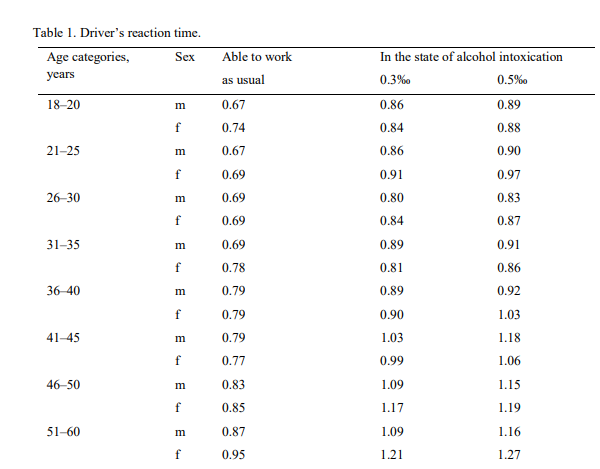

**Sacado de:** Podoprigora N, Stepina P., Dobromirov V. & Kotikov J. (2020).Determination of driver's reaction time in expert studies of road traffic accidents using software and hardware complex. Transportation Research Procedia, 50, 538–544. https://doi.org/10.1016/j.trpro.2020.10.064

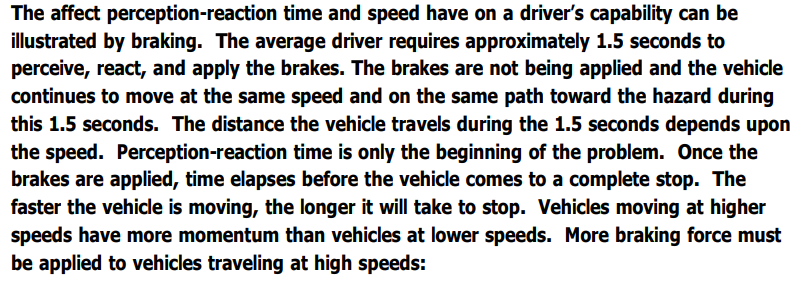

**Sacado de:** Speed-Measuring Device Operator Training. National Highway Traffic Safety Administration, part of the U.S. Department of Transportation.
 https://www.nhtsa.gov/sites/nhtsa.gov/files/documents/core_participant_manual-smd-2018.pdf

El modelo consta de una variable independiente, que es la velocidad a la que viaja el carro al percibir el estímulo, y tres parámetros: el tiempo de reacción $t_r$, el coeficiente de fricción $μ_{act}$ y el ángulo de la pendiente.

Para el parámetro relacionado con la inclinación de la vía, se asumirá que se está en una vía plana, es decir, con un ángulo de inclinación de 0 grados. Además, se fijará el parámetro del tiempo de reacción basado en los datos recolectados en el trabajo de Podoprigora et al. En este estudio se considera el tiempo de reacción de una persona con porcentajes de alcohol en la sangre, por lo que solo se tomará el promedio de los datos en un estado normal, sin discriminar entre géneros. El parámetro que se ajustará según los datos será el coeficiente de fricción de la vía, el cual depende de varios factores como el material de la vía, el estado de las llantas, los frenos, el clima, etc. También se harán adaptaciones al tiempo de reacción, estableciendo el tiempo promedio dado por el Departamento de Transporte de Estados Unidos.

## Simulación

### Modelo

In [57]:
#Parametros
angulo = 0
inclinacion = (angulo*np.pi)/180
gra = 9.8

#Funciones para el modelo

g = lambda x, t: t*x
h = lambda x, a, mu: (x**2)/(2*gra*np.cos(a)*(mu+(np.sin(2*a)/2)))

### Primeros Datos

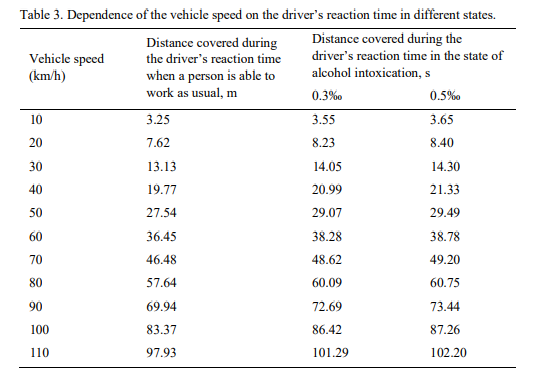

**Sacado de** Podoprigora N, Stepina P., Dobromirov V. & Kotikov J. (2020).Determination of driver's reaction time in expert studies of road traffic accidents using software and hardware complex. Transportation Research Procedia, 50, 538–544. https://doi.org/10.1016/j.trpro.2020.10.064

#### Evaluando el modelo

In [58]:
vel = np.array([(i+1)*10 for i in range(11)])/3.6 #Pasar de km/h -> m/s
distance = np.array([3.25, 7.62, 13.13, 19.77, 27.54, 36.45, 46.48, 57.64, 69.94, 83.37, 97.93]) #Esta en metros
coefFriccion = 0.8
tr_podoprigora = np.average(np.array([0.67, 0.74, 0.67, 0.69, 0.69, 0.69, 0.69, 0.78,0.79, 0.79,0.79, 0.77, 0.83, 0.85, 0.87, 0.95]))
tr_nhtsa = 1.5
f = lambda v, mu, t: g(v, t) + h(v, inclinacion, mu)
new_vel = np.linspace(vel[0]-1, vel[-1]+1, 100)

7.506165280927178


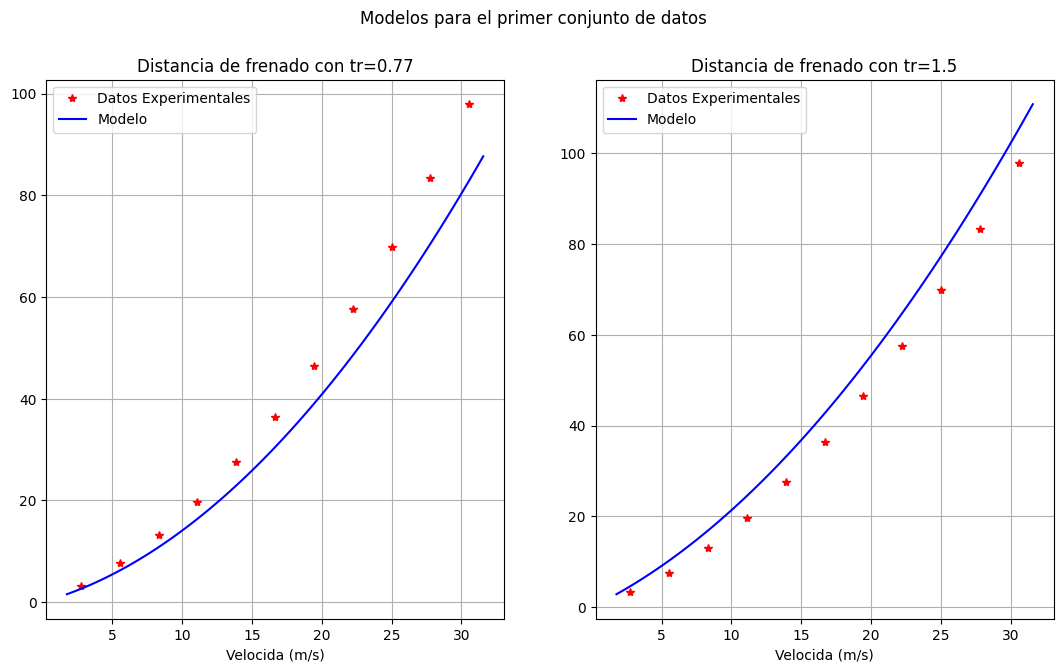

In [59]:
#Graficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

fig.suptitle("Modelos para el primer conjunto de datos")

ax1.plot(vel, distance, "r*", label="Datos Experimentales")
ax1.plot(new_vel, f(new_vel, coefFriccion, tr_podoprigora), "b-", label="Modelo")
ax1.set_title(f"Distancia de frenado con tr={tr_podoprigora:.02}")
ax1.set_xlabel("Velocida (m/s)")
ax1.legend()
ax1.grid()

ax2.plot(vel, distance, "r*", label="Datos Experimentales")
ax2.plot(new_vel, f(new_vel, coefFriccion, tr_nhtsa), "b-", label="Modelo")
ax2.set_title(f"Distancia de frenado con tr={tr_nhtsa:.02}")
ax2.set_xlabel("Velocida (m/s)")
ax2.legend()
ax2.grid()

print(max(f(vel, coefFriccion, tr_nhtsa) -distance))

**Resultados**: Al evaluar el modelo con un coeficiente de fricción $\mu$ fijo de 0.8 y tiempos de reacción de 0.77 y 1.5 segundos, observamos que en el primer caso tenemos una cota inferior en comparación con los datos experimentales. Esto indica una discrepancia entre los datos recolectados y los datos estimados, sugiriendo que se podría producir un accidente. Por lo tanto, es necesaria una mejor evaluación de los parámetros para ajustar adecuadamente el tiempo de reacción y el coeficiente de fricción. En la segunda configuración de parámetros, aunque también obtenemos una cota en los datos, esta es superior. A pesar de que no se ajusta completamente a los datos, se proporciona un margen de seguridad más amplio, lo que ayuda a evitar un accidente.

#### Adaptando el modelo

##### Minimos cuadrados no lineales coeficiente de fricción

In [60]:
r_podoprigora = lambda x: np.array([f(vel[i], x[0], tr_podoprigora) - distance[i] for i in range(len(distance))])
x_podoprigora, sms = gauss_newton(r_podoprigora, np.array([0.8]), tol=0.00001, iter=1000)
print(x_podoprigora)
print(sms)

r_nhtsa = lambda x: np.array([f(vel[i], x[0], tr_nhtsa) - distance[i] for i in range(len(distance))])
x_nhtsa, sms = gauss_newton(r_nhtsa, np.array([0.8]), tol=0.00001, iter=1000)
print(x_nhtsa)
print(sms)

[0.62957647]
Encontrado
[0.97470522]
Encontrado


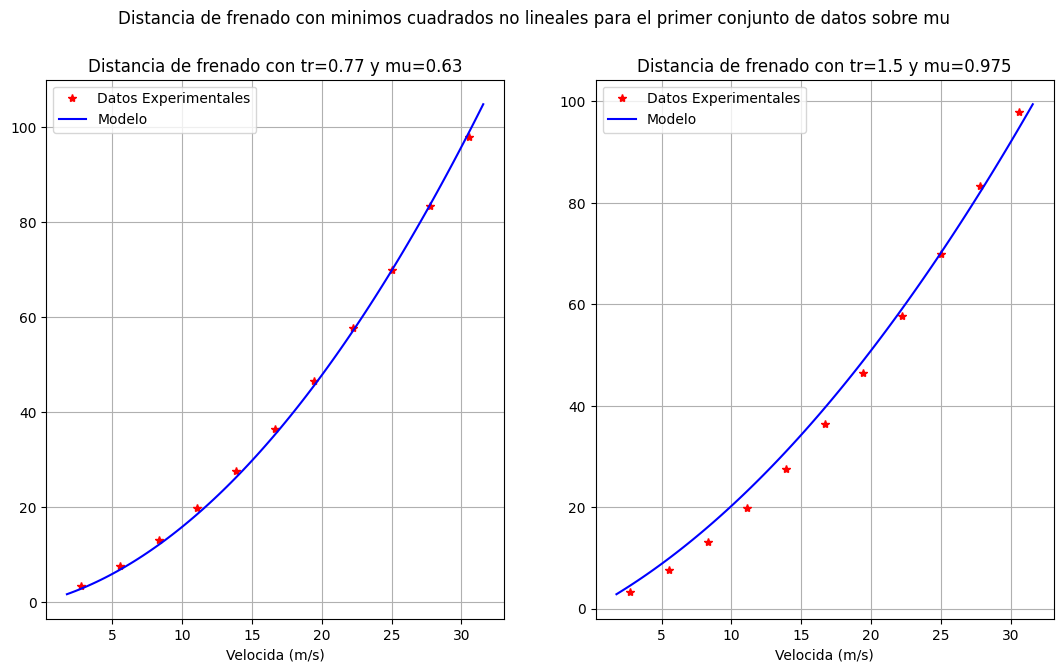

In [61]:
#Graficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

fig.suptitle("Distancia de frenado con minimos cuadrados no lineales para el primer conjunto de datos sobre mu")

ax1.plot(vel, distance, "r*", label="Datos Experimentales")
ax1.plot(new_vel, f(new_vel, x_podoprigora[0], tr_podoprigora), "b-", label="Modelo")
ax1.set_title(f"Distancia de frenado con tr={tr_podoprigora:.02} y mu={x_podoprigora[0]:.3}")
ax1.set_xlabel("Velocida (m/s)")
ax1.legend()
ax1.grid()

ax2.plot(vel, distance, "r*", label="Datos Experimentales")
ax2.plot(new_vel, f(new_vel, x_nhtsa[0], tr_nhtsa), "b-", label="Modelo")
ax2.set_title(f"Distancia de frenado con tr={tr_nhtsa:.02} y mu={x_nhtsa[0]:.3}")
ax2.set_xlabel("Velocida (m/s)")
ax2.legend()
ax2.grid()

**Resultados:** Por el método de mínimos cuadrados no lineales, se estimó que para el conjunto de datos con el tiempo de reacción promedio tomado del trabajo de Podoprigora, el coeficiente de fricción $\mu$ baja a 0.63. Este valor puede deberse a las condiciones de la carretera, el estado de los neumáticos y los frenos, lo que permite obtener condiciones más realistas de la carretera. Por otra parte, para el tiempo de reacción del NHTSA, se estimó un coeficiente de fricción de 0.97, lo que indica que el agarre de los neumáticos y los frenos con la carretera es casi perfecto. Este resultado es inusual debido a los factores mencionados anteriormente. Dado que el valor de $\mu$ está dentro del rango del coeficiente de fricción del cemento, es extraño que, si el carro está en movimiento, exista un agarre de tal magnitud.

##### Minimos cuadrados no lineales tiempo de reacción

In [62]:
coefFriccion = 0.8

r = lambda x: np.array([f(vel[i], coefFriccion, x[0]) - distance[i] for i in range(len(distance))])
x, sms = gauss_newton(r, np.array([1]), tol=0.00001, iter=1000)
print(x)
print(sms)

[1.19238632]
Encontrado


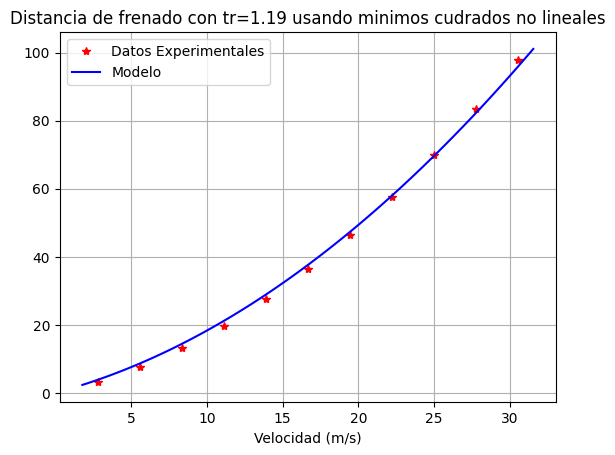

In [63]:
#Graficos
plt.plot(vel, distance, "r*", label="Datos Experimentales")
plt.plot(new_vel, f(new_vel, coefFriccion, x[0]), "b-", label="Modelo")
plt.title(f"Distancia de frenado con tr={x[0]:.3} usando minimos cudrados no lineales")
plt.xlabel("Velocidad (m/s)")
plt.legend()
plt.grid()

**Resultados:** El tiempo de reacción, calculado mediante el método de mínimos cuadrados, se estima en aproximadamente 1.19 segundos, lo cual está en el rango entre el promedio del tiempo del trabajo de Podoprigora y el valor dado por la NHTSA. Esto sugiere que, si el coeficiente de fricción de la carretera está en el valor estimado considerando únicamente el material con el que se construyó, se puede evitar un accidente con un tiempo de reacción ligeramente más lento que el establecido por la NHTSA pero más alto que el obtenido por Podoprigora.


##### Minimos cuadrados no lineales tiempo de reacción y coeficiente de fricción

In [64]:
valores_iniciales = np.array([0.8, (tr_podoprigora+tr_nhtsa)/2])

r = lambda x: np.array([f(vel[i], x[0], x[1]) - distance[i] for i in range(len(distance))])
x, sms = gauss_newton(r, valores_iniciales, tol=0.00001, iter=10000)
print(x)
print(sms)

[0.70163118 0.97953466]
Encontrado


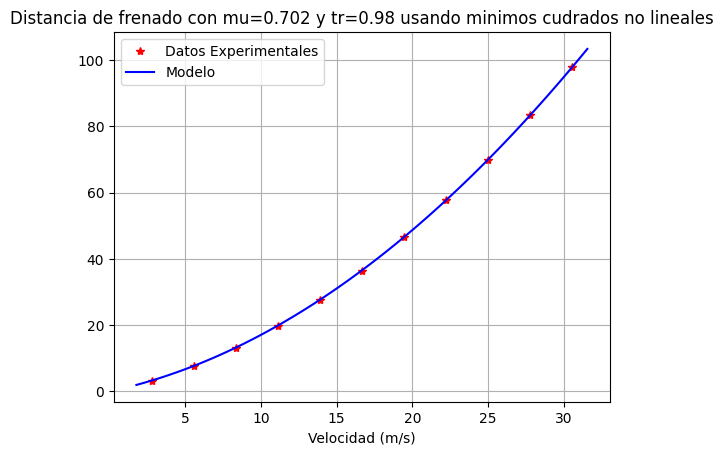

In [65]:
#graficos
plt.plot(vel, distance, "r*", label="Datos Experimentales")
plt.plot(new_vel, f(new_vel, x[0], x[1]), "b-", label="Modelo")
plt.title(f"Distancia de frenado con mu={x[0]:.3} y tr={x[1]:.3} usando minimos cudrados no lineales")
plt.xlabel("Velocidad (m/s)")
plt.legend()
plt.grid()
plt.show()

**Resultados:** Usando el método de mínimos cuadrados no lineales con un valor de fricción del cemento de 0.8 y el tiempo promedio entre los tiempos estudiados, se observa que el tiempo de reacción disminuye más que en la estimación anterior, así como el coeficiente de fricción. Esto se puede explicar por el estado de la vía, el estado de los neumáticos o los frenos. Aunque el tiempo también disminuye, sigue estando dentro del rango esperado.

### Segundos Datos

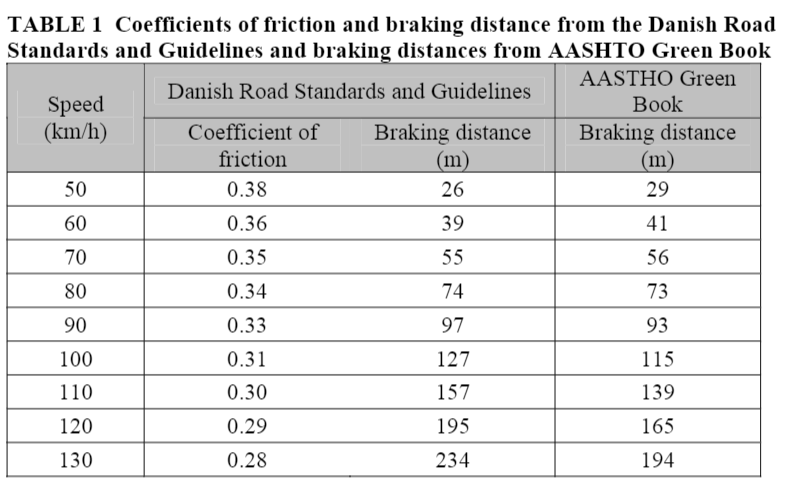

**Sacado de:** Greibe, Poul. (2014). DETERMINATION OF BRAKING DISTANCE AND DRIVER BEHAVIOUR BASED ON BRAKING TRIALS. [Online 13/08/2024] https://www.researchgate.net/publication/242572582_DETERMINATION_OF_BRAKING_DISTANCE_AND_DRIVER_BEHAVIOUR_BASED_ON_BRAKING_TRIALS


#### Evaluando el modelo

In [66]:
vel = np.array([(i+5)*10 for i in range(9)])/3.6 #Pasar de km/h -> m/s
distance = np.array([26, 39, 55, 74, 97, 127, 157, 195, 234]) #Esta en metros
fric = np.array([0.38, 0.36, 0.35, 0.34, 0.33, 0.31, 0.30, 0.29, 0.28])
coefFriccion = np.average(fric)
new_vel = np.linspace(vel[0]-1, vel[-1]+1, 100)

print(max(f(vel, coefFriccion, tr_nhtsa)-distance))
print(max(f(vel, coefFriccion, tr_podoprigora)-distance))

38.11557684298208
20.1561347895167


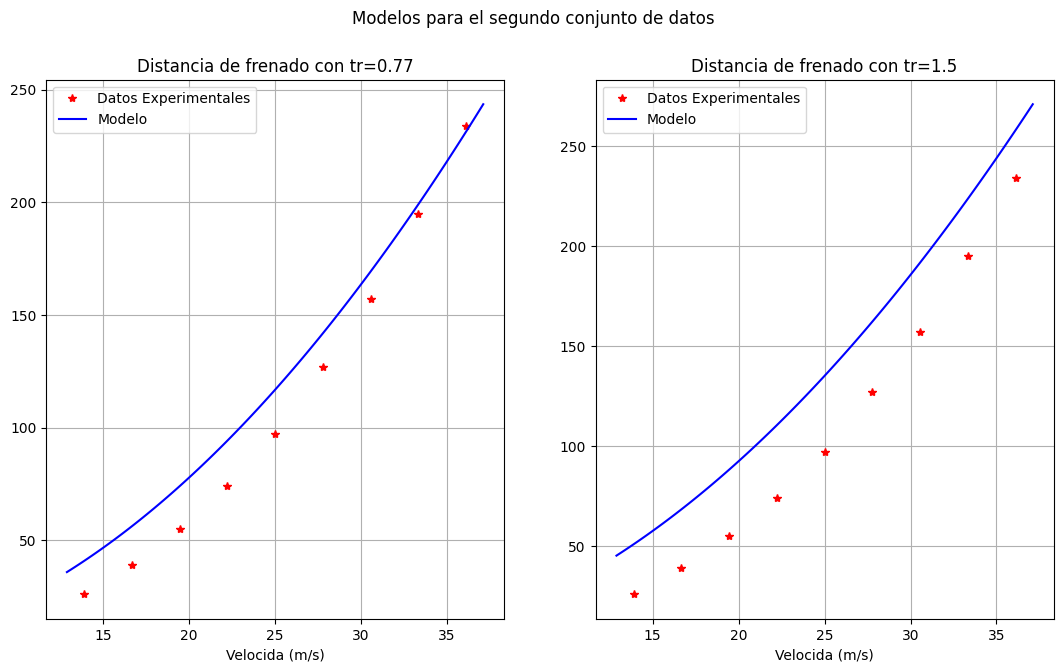

In [67]:
#Graficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

fig.suptitle("Modelos para el segundo conjunto de datos")

ax1.plot(vel, distance, "r*", label="Datos Experimentales")
ax1.plot(new_vel, f(new_vel, coefFriccion, tr_podoprigora), "b-", label="Modelo")
ax1.set_title(f"Distancia de frenado con tr={tr_podoprigora:.02}")
ax1.set_xlabel("Velocida (m/s)")
ax1.legend()
ax1.grid()

ax2.plot(vel, distance, "r*", label="Datos Experimentales")
ax2.plot(new_vel, f(new_vel, coefFriccion, tr_nhtsa), "b-", label="Modelo")
ax2.set_title(f"Distancia de frenado con tr={tr_nhtsa:.02}")
ax2.set_xlabel("Velocida (m/s)")
ax2.legend()
ax2.grid()


**Resultados** Para este conjunto de datos, se observa que con el tiempo promedio, los datos se encuentran como una cota superior hasta una velocidad de aproximadamente 130 km/h, proporcionando una distancia de seguridad suficiente para evitar un accidente. Lo mismo ocurre al asumir el tiempo de reacción del Departamento de Transporte de los EE. UU.

#### Adaptando el modelo

##### Coeficiente de fricción variables

In [68]:
from bisect import bisect_left

new_fric = []
for e in new_vel:
  index = bisect_left(vel, e)
  new_fric.append(fric[index-1] if index >= len(vel) else fric[index])

new_fric = np.array(new_fric)

print(max(f(vel, fric, tr_nhtsa)-distance))
print(max(f(vel, fric, tr_podoprigora)-distance))

57.778245689810205
31.281717912032377


38.11557684298208


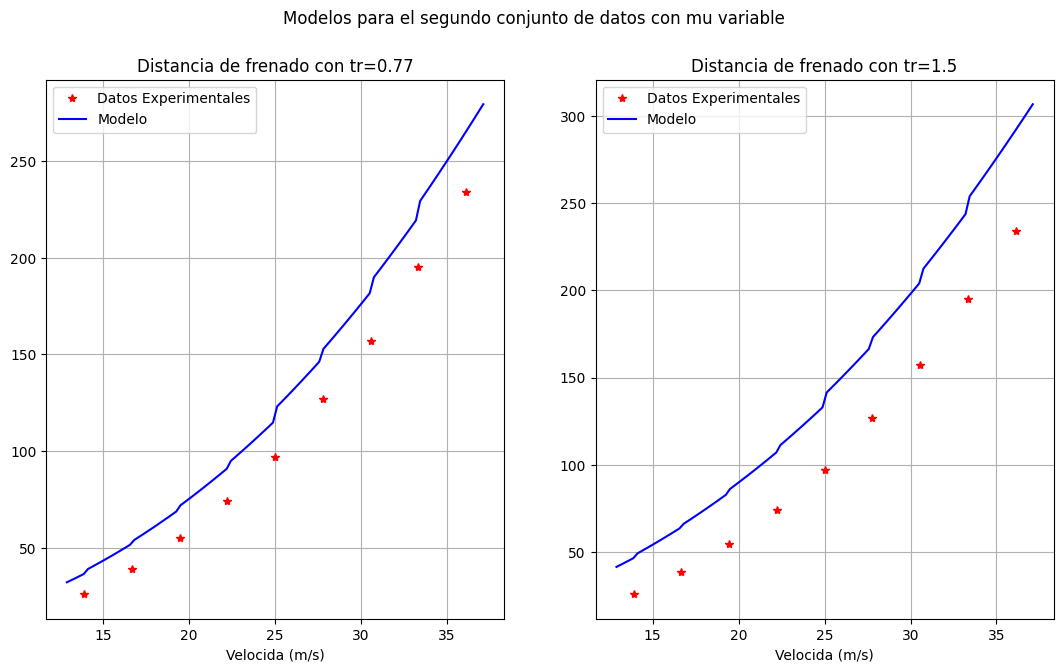

In [69]:
#Graficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

fig.suptitle("Modelos para el segundo conjunto de datos con mu variable")

ax1.plot(vel, distance, "r*", label="Datos Experimentales")
ax1.plot(new_vel, f(new_vel, new_fric, tr_podoprigora), "b-", label="Modelo")
ax1.set_title(f"Distancia de frenado con tr={tr_podoprigora:.02}")
ax1.set_xlabel("Velocida (m/s)")
ax1.legend()
ax1.grid()

ax2.plot(vel, distance, "r*", label="Datos Experimentales")
ax2.plot(new_vel, f(new_vel, new_fric, tr_nhtsa), "b-", label="Modelo")
ax2.set_title(f"Distancia de frenado con tr={tr_nhtsa:.02}")
ax2.set_xlabel("Velocida (m/s)")
ax2.legend()
ax2.grid()
print(max(f(vel, coefFriccion, tr_nhtsa) -distance))

**Resultados** Esta vez, logramos que todas las aproximaciones se sitúen como cota superior, por lo que el modelo estima una distancia mayor que la experimental, proporcionando así una mayor distancia de seguridad.

##### Minimos cuadrados no lineales sobre el coeficiente de fricción

In [70]:
r_podoprigora = lambda x: np.array([f(vel[i], x[0], tr_podoprigora) - distance[i] for i in range(len(distance))])
x_podoprigora, sms = gauss_newton(r_podoprigora, np.array([0.8]), tol=0.00001, iter=1000)
print(x_podoprigora)
print(sms)

r_nhtsa = lambda x: np.array([f(vel[i], x[0], tr_nhtsa) - distance[i] for i in range(len(distance))])
x_nhtsa, sms = gauss_newton(r_nhtsa, np.array([0.8]), tol=0.00001, iter=1000)
print(x_nhtsa)
print(sms)

[0.3531741]
Encontrado
[0.42439659]
Encontrado


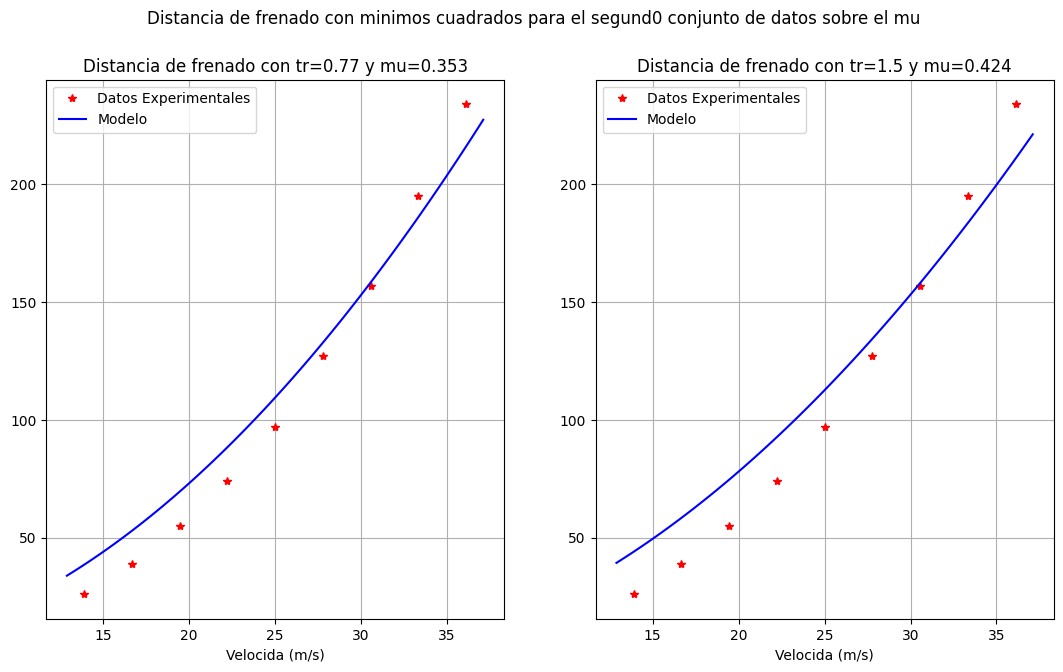

In [71]:
#Graficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

fig.suptitle("Distancia de frenado con minimos cuadrados para el segund0 conjunto de datos sobre el mu")

ax1.plot(vel, distance, "r*", label="Datos Experimentales")
ax1.plot(new_vel, f(new_vel, x_podoprigora[0], tr_podoprigora), "b-", label="Modelo")
ax1.set_title(f"Distancia de frenado con tr={tr_podoprigora:.02} y mu={x_podoprigora[0]:.3}")
ax1.set_xlabel("Velocida (m/s)")
ax1.legend()
ax1.grid()

ax2.plot(vel, distance, "r*", label="Datos Experimentales")
ax2.plot(new_vel, f(new_vel, x_nhtsa[0], tr_nhtsa), "b-", label="Modelo")
ax2.set_title(f"Distancia de frenado con tr={tr_nhtsa:.02} y mu={x_nhtsa[0]:.3}")
ax2.set_xlabel("Velocida (m/s)")
ax2.legend()
ax2.grid()

**Resultados:** Usando el método de mínimos cuadrados no lineales, se estimó que el coeficiente de fricción que mejor se adapta al conjunto de datos es 0.35 para un tiempo de reacción de 0.77 segundos y 0.424 para un tiempo de 1.5 segundos. Ambos valores son útiles para evitar un choque a velocidades inferiores a 110 km/h. Por lo tanto, una estimación por partes podría ser beneficiosa al ajustar este parámetro.

##### Minimos cuadrados no lineales sobre el tiempo de reacción

In [72]:
r = lambda x: np.array([f(vel[i], coefFriccion, x[0]) - distance[i] for i in range(len(distance))])
x, sms = gauss_newton(r, np.array([1.5]), tol=0.00001, iter=1000)
print(x)
print(sms)

[0.33532148]
Encontrado


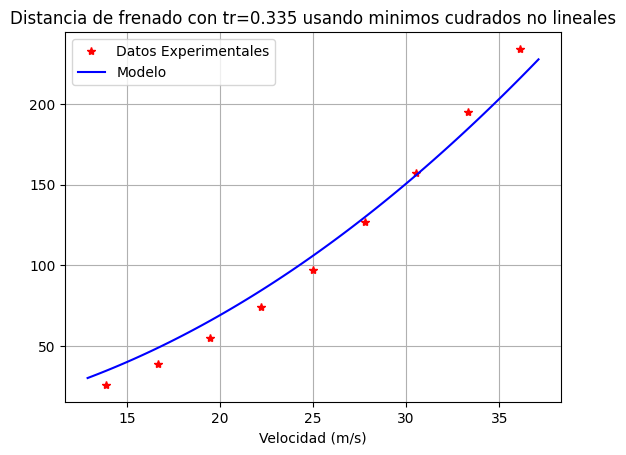

In [73]:
#Graficos
plt.plot(vel, distance, "r*", label="Datos Experimentales")
plt.plot(new_vel, f(new_vel, coefFriccion, x[0]), "b-", label="Modelo")
plt.title(f"Distancia de frenado con tr={x[0]:.3} usando minimos cudrados no lineales")
plt.xlabel("Velocidad (m/s)")
plt.legend()
plt.grid()

**Resultados:** Usando el método de mínimos cuadrados no lineales, se estimó que el tiempo de reacción que mejor se adapta al conjunto de datos es de 0.335 segundos. Sin embargo, este valor es muy bajo en comparación con el rango utilizado previamente, lo que sugiere que es poco probable que un tiempo de reacción tan corto sea realista.

##### Minimos cuadrados no lineales tiempo de reacción y coeficiente de fricción

In [74]:
valores_iniciales = np.array([coefFriccion, (1)])

r = lambda x: np.array([f(vel[i], x[0], x[1]) - distance[i] for i in range(len(distance))])
x, sms = gauss_newton(r, valores_iniciales, tol=0.00001, iter=10000)
print(x)
print(sms)

[ 0.23658814 -1.37742596]
Encontrado


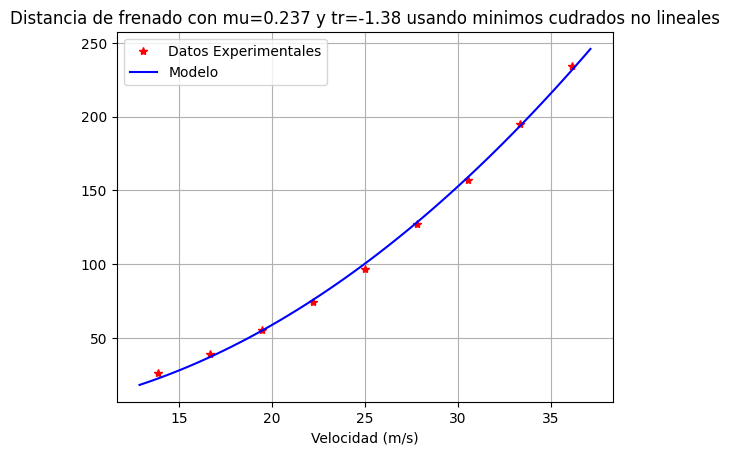

In [75]:
#graficos
plt.plot(vel, distance, "r*", label="Datos Experimentales")
plt.plot(new_vel, f(new_vel, x[0], x[1]), "b-", label="Modelo")
plt.title(f"Distancia de frenado con mu={x[0]:.3} y tr={x[1]:.3} usando minimos cudrados no lineales")
plt.xlabel("Velocidad (m/s)")
plt.legend()
plt.grid()
plt.show()

**Resultados:** Usando el método de mínimos cuadrados no lineales con los valores promedio de fricción y el tiempo promedio entre los tiempos estudiados, se observa que el tiempo de reacción disminuye a valores negativos, lo cual no tiene sentido. Además, el coeficiente de fricción también disminuye, lo que sugiere un peor estado de los frenos, los neumáticos o la carretera para detener el vehículo a tiempo. No obstante, estos parámetros no son realistas, ya que implican un tiempo de reacción que sugiere que el vehículo ya estaba frenando antes del choque, lo cual no corresponde a una situación práctica.

## Conclusiones

La estimación de parámetros para el modelo con distintos conjuntos de datos resulta ser una tarea laboriosa, ya que trabajamos con parámetros difíciles de estimar, como el tiempo de reacción de una persona en una situación de emergencia y el coeficiente de fricción de una carretera, que depende de varios factores además del material de la superficie. Sin embargo, al simplificar el modelo utilizando datos promedio de estudios previos, el modelo logra ajustarse a los datos y resulta coherente en varios aspectos, actuando como una cota superior que proporciona una distancia de seguridad de aproximadamente 20-30 metros.

Por lo tanto, este modelo puede ser útil para la seguridad vial, ya que, con parámetros reales, permite estimar con cierto grado de precisión si la distancia entre dos vehículos era adecuada en el momento de un accidente, dado un coeficiente de fricción de la carretera según su estado. Este mismo enfoque es aplicable a la planificación de vías, ya que permite calcular la distancia de seguridad necesaria en una carretera basada en un coeficiente de fricción estimado.

También es necesario evaluar la predicción del modelo en carreteras con inclinación para determinar su desempeño en esas condiciones.

## Bibliografia

Nota: Poner en formato de Citaciones

*   https://www.researchgate.net/profile/Said-Easa/publication/275348114_Modeling_reaction_time_in_car-following_behaviour_based_on_human_factors/links/5539fbc70cf247b858815199/Modeling-reaction-time-in-car-following-behaviour-based-on-human-factors.pdf
*   https://www.dgt.es/muevete-con-seguridad/evita-conductas-de-riesgo/distracciones-al-conducir/#:~:text=El%20alcohol%2C%20las%20drogas%20y,se%20prolonga%20en%20el%20tiempo.

*   https://hadron.physics.fsu.edu/~crede/TEACHING/PHY2048C/Calendar/W6_D1/Friction%20Coefficients.html

*   https://people.reed.edu/~jones/141/BrakingDist.html

*  https://www.brake.org.uk/get-involved/take-action/mybrake/knowledge-centre/speed/stopping-distances

*  https://www.kaggle.com/datasets/liantsoarandria/braking-distance-estimate

* https://doi.org/10.1016/j.trpro.2020.10.064

* https://www.researchgate.net/publication/242572582_DETERMINATION_OF_BRAKING_DISTANCE_AND_DRIVER_BEHAVIOUR_BASED_ON_BRAKING_TRIALS

